# 밑바닥부터시작하는딥러닝2

## 2.1 자연어 처리란
- NLP: Natural Language Processing 자연어를 처리하는 분야
- 우리의 말을 컴퓨터에게 이해시키기 위한 기술

## 2.2 시소러스
- 시소러스 thesaurus: 유의어사전
- 뜻이 같은 단어(동의어) = 뜻이 비슷한 단어(유의어)
- 단어 네트워크를 이용해 컴퓨터에게 단어 사이의 관계 가르침

### 2.2.1 WordNet

### 2.2.2 시소러스의 문제점
- 시대 변화에 대응하기 어렵다
- 사람을 쓰는 비용은 크다
- 단어의 미묘한 차이를 표현할 수 없다

## 2.3 통계 기반 기법

### 2.3.1 파이썬으로 말뭉치 전처리하기

In [1]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [2]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
        
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [3]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 2.3.2 단어의 분산 표현
- 분산 표현: 단어의 의미를 정확하게 파악할 수 있는 벡터 표현

### 2.3.3 분포 가설
- 분포 가설: 단어의 의미는 주변 단어에 의해 형성된다
- 즉 단어 자체에는 의미가 없고 그 단어가 사용된 '맥락'이 의미 형성
- 맥락: 특정 단어를 중심에 둔 그 주변 단어
- 윈도우 크기: 맥락의 크기 (주변 단어를 몇 개나 포함할지)

### 2.3.4 동시발생행렬 co-occurrence matrix
- 그 주변에 어떤 단어가 몇 번이나 등장하는지를 세어 집계하는 방법 (통계기반)

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [8]:
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)

co_matrix

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

### 2.3.5 벡터 간 유사도
- 벡터 사이의 유사도 측정 => 코사인 유사도 cosine similarity

### $ similarity(x, y) = {xy\over||x||||y|| } $

In [9]:
# devide by zero error !
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

# + epsilon
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시
##### most_similar(query, word_to_id, id_to_word, word_matrix, top=5)
- query: 검색어(단어)
- word_to_id: 단어에서 단어ID로의 딕셔너리
- id_to_word: 단어ID에서 단어로의 딕셔너리
- word_matirx: 단어벡터들을 한데 모은 행렬, 각 행에는 대응하는 단어의 벡터가 저장되어 있다고 가정
- top: 상위 몇 개까지 출력할지 결정

In [11]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 1. 검색어 꺼낸다
    if query not in word_to_id:
        print("%s(을)를 찾을 수 없습니다." %query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    
    # 2. 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
        
    # 3. 코사인 유사도를 기준으로 내림차순 출력
    count = 0
    for i in (-1*similarity).argsort():   # 내림차순 index
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선하기

### 2.4.1 상호정보량
#### 점별 상호정보량 (Pointwise Mutual Information, PMI)
### $ PMI(x, y) = log_2{P(x,y)\over P(x)P(y) } $
- P(x): x가 일어날 확률
- P(y): y가 일어날 확률
- P(x, y): x와 y가 동시에 일어날 확률

#### 동시발생행렬 사용
### $ PMI(x, y) = log_2{P(x,y)\over P(x)P(y)} = log_2{{C(x, y)\over N}\over {{C(x) \over N} {C(y) \over N}}} = log_2{C(x,y)\cdot N\over C(x)C(y)} $
- N: 말뭉치에 포함된 단어
- C: 동시발생 행렬
- C(x, y): x와 y가 동시발생하는 횟수
- C(x), C(y): x, y의 등장 횟수

#### 양의 상호정보량 (Positive PMI, PPMI)
### $ PPMI(x, y) = max(0, PMI(x, y)) $
- PMI의 문제: 두 단어의 동시발생 횟수가 0이면 $log_20= -\infty$

In [13]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j]*N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.1f%% 완료' %(100*cnt/total))
                    
    return M

In [14]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시 발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시 발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 2.4.2 차원 감소 Dimensionality reduction
- 중요한 정보는 최대한 유지하면서 차원 줄이기
- 특이값 분해 (Singular Value Decomposition, SVD)
### $ X = USV^T $


- U, V: 직교행렬, S: 대각행렬

### 2.4.3 SVD에 의한 차원 감소

In [18]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

print("동시발생행렬:", C[0])
print("PPMI행렬:", W[0])
print("SVD:", U[0])
print("2차원벡터로 줄이기:", U[0, :2])

동시발생행렬: [0 1 0 0 0 0 0]
PPMI행렬: [0.    1.807 0.    0.    0.    0.    0.   ]
SVD: [-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
2차원벡터로 줄이기: [-3.409e-01 -1.110e-16]


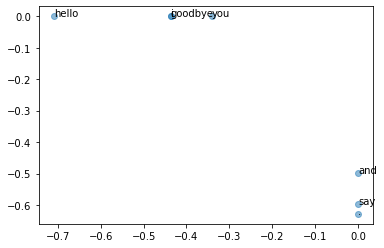

In [22]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제접
- 어휘가 너무 많아 이런 거대 행렬에 SVD를 적용하기 힘들다
- 통계 기밥 기법(배치 학습) vs 추론 기밥 기법(미니배치 학습)

### 3.1.2 추론 기반 기법 개요
- 단어의 출현 패턴 학습
- 모델은 맥락 정보를 입력받아 각 단어의 출현 확률을 출력

### 3.1.3 신경망에서의 단어 처리
- 원핫인코딩 one-hot encoding
- 단어를 고정 길이 벡터로 변환하면 신경망의 입력층은 뉴련의 수를 고정할 수 있다
### $ c \cdot W = h $
- 가중치의 행벡터 하나를 뽑아낸 것과 같은데 np.matmul 사용하면 계산량 많아진다

In [32]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])   # 입력
W = np.random.randn(7, 3)       # 가중치 
h = np.matmul(c, W)             # 중간 노드
print(h)

[[-0.391 -0.678 -1.069]]


In [33]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

C = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(C)
print(h)

[[-0.062  0.8    1.133]]


## 3.2 단순한 word2vec

### 3.2.1 CBOW 모델의 추론 처리
#### CBOW (continuous bag-of-words)
- 맥락으로 부터 타깃(target)을 추측하는 용도의 신경망
- $h_1$: 첫번째 입력층, $h_2$: 두번째 입력층
- ${1 \over 2} (h_1+h_2)$: 은닉층
- $W_{in}$: 두 입력층 => 은닉층, 완전연결계층의 가중치(단어 분산 표현)
- $W_{out}$: 은닉층 => 출력층

In [36]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# input: two words (one hot)
c0 = np.array([[1,0,0,0,0,0,0]])   # you
c1 = np.array([[0,0,1,0,0,0,0]])   # goodbye

# weights: random
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# Layers
in_layer_0 = MatMul(W_in)
in_layer_1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward
h0 = in_layer_0.forward(c0)
h1 = in_layer_1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)   # word's score

[[ 0.073  1.558  1.394  3.299 -0.071 -2.75  -2.919]]


### 3.2.2 CBOW 모델의 학습
- 위의 각 단어의 점수를 출력한 걸 토대로 소프트맥스함수를 적용하면 "확률" 얻을 수 있음
- CBOW 모델의 학습: 올바를 예측을 할 수 있도록 가중치 조정
- $W_{in}$에 단어의 출현 패턴을 파악한 벡터 학습
- 다중 클래스 분류를 수행함
- 소프트맥스함수로 점수를 확률로 변환
- 그 확률과 정답 레이블로부터 교차 엔트로피 오차 구한 후, 이 값을 손실로 사용해 학습

### 3.2.3 word2vec의 가중치와 분산 표현
입력, 완전연결계층의 가중치 $W_{in}$ : 각 행이 각 단어의 분산 표현

출력, 완전연결계층의 가중치 $W_{out}$ : 단어의 의미가 인코딩된 벡터가 저장되고 있다

1. 입력 층의 가중치만 이용  =>  word2vec
2. 출력 층의 가중치만 이용
3. 양쪽 가중치를 모두 이용

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃
- 맥락: word2vec에서 이용하는 신경망의 입력
- 타깃: 그 정답 레이블은 맥락에 둘러싸인 중앙의 단어
- 신경망에 "맥락"을 입력했을 때 "타깃"이 출현할 확률 높이기

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
def create_context_target(corpus, window_size=1):
    
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx + t])
            
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [10]:
contexts, target = create_context_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

In [15]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print("target:\n", target)
print("contexts:\n", contexts)

target:
 [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
contexts:
 [[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

In [22]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class simpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다
        self.word_vecs = W_in
        
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 233 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 234 |  반복 1 / 2 | 시간 0[s] | 손실 1.26
| 에폭 235 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 236 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 237 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 238 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 239 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 240 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 241 |  반복 1 / 2 | 시간 0[s] | 손실 1.24
| 에폭 242 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 243 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 257 |  반복 1

| 에폭 507 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 508 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 509 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 510 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 511 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 512 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 513 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 514 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 515 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 516 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 517 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 518 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 521 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 522 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 523 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 524 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 525 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 526 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 527 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 528 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 529 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 530 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 531 |  반복 1

| 에폭 754 |  반복 1 / 2 | 시간 1[s] | 손실 0.78
| 에폭 755 |  반복 1 / 2 | 시간 1[s] | 손실 0.71
| 에폭 756 |  반복 1 / 2 | 시간 1[s] | 손실 0.77
| 에폭 757 |  반복 1 / 2 | 시간 1[s] | 손실 0.66
| 에폭 758 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 759 |  반복 1 / 2 | 시간 1[s] | 손실 0.70
| 에폭 760 |  반복 1 / 2 | 시간 1[s] | 손실 0.75
| 에폭 761 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 762 |  반복 1 / 2 | 시간 1[s] | 손실 0.70
| 에폭 763 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 764 |  반복 1 / 2 | 시간 1[s] | 손실 0.65
| 에폭 765 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 766 |  반복 1 / 2 | 시간 1[s] | 손실 0.74
| 에폭 767 |  반복 1 / 2 | 시간 1[s] | 손실 0.77
| 에폭 768 |  반복 1 / 2 | 시간 1[s] | 손실 0.55
| 에폭 769 |  반복 1 / 2 | 시간 1[s] | 손실 0.86
| 에폭 770 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 771 |  반복 1 / 2 | 시간 1[s] | 손실 0.64
| 에폭 772 |  반복 1 / 2 | 시간 1[s] | 손실 0.76
| 에폭 773 |  반복 1 / 2 | 시간 1[s] | 손실 0.69
| 에폭 774 |  반복 1 / 2 | 시간 1[s] | 손실 0.75
| 에폭 775 |  반복 1 / 2 | 시간 1[s] | 손실 0.70
| 에폭 776 |  반복 1 / 2 | 시간 1[s] | 손실 0.64
| 에폭 777 |  반복 1 / 2 | 시간 1[s] | 손실 0.75
| 에폭 778 |  반복 1

C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\eunbi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from cur

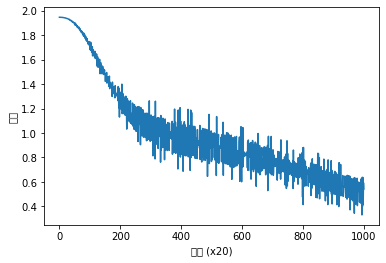

In [25]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
#from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = simpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [26]:
# 밀집벡터: 단어의 분산표현

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.88570744 -0.9957745  -1.6699766   0.90276045 -0.9489839 ]
say [ 1.1528203  0.7737249 -1.3374393 -1.1625279  1.1576147]
goodbye [-1.0690522  -0.99726874 -0.01653015  0.9874587  -0.92388856]
and [ 0.523455   1.9891618 -1.202602  -0.5396223  0.5409955]
i [-1.0398458  -0.99237984 -0.01988868  0.9772534  -0.93040025]
hello [-0.88631266 -0.9806779  -1.6627138   0.8935393  -0.9502012 ]
. [ 1.3956754 -1.4012275 -1.0576149 -1.4291105  1.4262311]


## 3.5 word2vec 보충
### $P(w_t|w_{t-1}, w_{t+1})$
- $w_{t-1}$과 $w_{t+1}$이 일어난 후 $w_t$가 일어날 확률

## 5.1 확률과 언어 모델
### $P(w_t|w_{t-1}, w_{t+1})$
### $P(w_t|w_{t-2}, w_{t-1})$
### $L=-logP(w_t|w_{t-2}, w_{t-1})$
### $P(w_1, ..., w_m)=\prod_{t=1}^m P(w_t|w_1, ..., w_{t-1})=\prod_{t=1}^m P(w_t|w_{t-2}, w_{t-1})$


## 5.2 RNN
- RNN (Recurrent Neural Network): 순환 신경망
### $h_t=RNN(x_t, h_{t-1})=tanh(h_{t-1}w_h+x_tw_x+b)$